# Gamma factor calculation script algorithm
## Authors: Marcela Hernández and Esteban Soto
### CICIMA UCR

#### The gamma factor is the ratio between the maximum reflectance peak in the visible/UV range and the maximum reflectance peak in the IR range

conda install pandas, matplotlib

In [1]:
import pandas as pd #Data analysis
import numpy as np  #Array and numeric methods
from matplotlib.backends.backend_pdf import PdfPages #pri*nt PDFS
import matplotlib #pri*nt graphs
import matplotlib.pyplot as plt #pri*nt graphs
import os #operating system
import re #regular expression manipulation
from datetime import datetime #date and time methods
import logging #to log errors

#import spectraltools
#This script requires the file spectraltools.py to work
import sys
# Add the external folder to the system path
current_dir = os.getcwd()
external_folder_path = os.path.abspath(os.path.join(current_dir, '../libraries'))
sys.path.append(external_folder_path)

#This line of code allow us to access data in colab
#functionality to reload modules

import importlib
import spectraltools
import metrics
import datapath_selector

# clear the import cache
importlib.reload(metrics)
importlib.reload(spectraltools)
importlib.reload(datapath_selector)
# now you can import my_class and it'll be updated
from metrics import *
from spectraltools import *
from datapath_selector import get_paths
from pathlib import Path

In [2]:
#open(r"/content/drive/My Drive/CICIMA/escarabajos_files/L1050_data", "r")

In [3]:
#Instructions: 
#parent folder path
date = str(datetime.today().date())
current_date = date

parent_folder_data_path = Path(r"C:\Users\esteb\cicima\escarabajos\test\data\test_step_jump_correction\files") 
#corrected_files_data_path = Path(r"C:\Users\esteb\cicima\escarabajos\test\data\test_step_jump_correction\corrected_files_2024-10-28\2024-10-28\files")


#create a subfolder called report with the correction process info  
report_path = ((parent_folder_data_path.parent / "reports" )/ f"{date}") / (parent_folder_data_path.name)
#pri*nt(report_path)
report_path.mkdir(parents=True, exist_ok=True)
report_location = report_path


In [4]:
#variables

prominence_threshold_min = 0.15
prominence_threshold_max = 0.60
min_height_threshold_denominator = 3.0
max_height_threshold_denominator = 2.5
min_distance_between_peaks = 125 #nm
uv_vis_min_wavelength = 400 
uv_vis_ir_limit_wavelength = 625 
ir_max_wavelength = 1500
#amount of specimens that would overlap with other species region
percentile_differentiation_amount = 0.25

min_wavelength_critical_points = 525
max_wavelength_critical_points = 1000

## Collections

In [5]:
"""OPTIONS: cicima_laptop, colaboratory, wfh, cicima_desktop
    """
collection_paths = get_paths()
#pri*nt(collection_paths)

inbio_2018_2019_collection = Specimen_Collection("INBIO", collection_paths["2018_2019_inbio_collection_path"] , collection_paths["2018_2019_inbio_collection_metadata"] , "HIGH")
angsol_collection = Specimen_Collection("ANGSOL", collection_paths["angsol_collection_path"] , collection_paths["angsol_collection_metadata"] , "HIGH")
angsol_collection.set_description("ANGSOL collection has specimens that belong to Angel Solís. The confidence that we have about specimen identification is high.")

cicimaucr_collection = Specimen_Collection("CICIMAUCR1", collection_paths["cicimaucr_collection_path"] , collection_paths["cicima_ucr_metadata"] , "HIGH")
cicimaucr_collection_2 = Specimen_Collection("CICIMAUCR2", collection_paths["cicimaucr_collection_2_path"] , collection_paths["cicima_ucr_metadata"] , "HIGH")
cicimaucr_collection_3 = Specimen_Collection("CICIMAUCR3", collection_paths["cicimaucr_collection_3_path"] , collection_paths["cicima_ucr_metadata"] , "HIGH")
inbucr_collection = Specimen_Collection("INBUCR", collection_paths["inbucr_collection_path"] , collection_paths["inbucr_metadata"] , "HIGH")
bioucr_collection = Specimen_Collection("BIOUCR", collection_paths["bioucr_collection_path"] , collection_paths["bioucr_metadata"] , "LOW")
aggregated_data_location = collection_paths["aggregated_data_location"] 
aggregated_data_avg_path = collection_paths["aggregated_data_avg_path"]
aggregated_data_std_path = collection_paths["aggregated_data_std_path"]


In [6]:
collection_list_training = [
                    #inbio_2018_2019_collection,
                    angsol_collection,
                    cicimaucr_collection,
                    cicimaucr_collection_2,
                    cicimaucr_collection_3,
                    inbucr_collection,
                    #bioucr_collection,
                    ]

collection_list_inbio = [
                    inbio_2018_2019_collection,
                    #angsol_collection,
                    #cicimaucr_collection,
                    #cicimaucr_collection_2,
                    #cicimaucr_collection_3,
                    #inbucr_collection,
                    #bioucr_collection,
                    ]
collection_list = collection_list_inbio
training_data_is_used = False
codes_in_collection = []
for collection in collection_list:
    codes_in_collection += collection.get_codes()
#print(codes_in_collection)

### Functions

In [7]:
def create_path_if_not_exists(path):
        # Check if the path already exists
        if not os.path.exists(path):
            # Create the directory and any missing parent directories
            os.makedirs(path)
            print(f"Directory '{path}' created successfully.")
        else:
            print(f"Directory '{path}' already exists.")

In [8]:
### Third test: Plots on demand
#!pip install reportlab
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, PageBreak, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.enums import TA_CENTER
import matplotlib.pyplot as plt
import numpy as np



#styles
def styles():
    # Title
    title_style = getSampleStyleSheet()["Title"]

    # Heading1 - Heading6
    heading1_style = getSampleStyleSheet()["Heading1"]
    heading2_style = getSampleStyleSheet()["Heading2"]
    # You can similarly access Heading3, Heading4, Heading5, Heading6

    # Normal
    normal_style = getSampleStyleSheet()["Normal"]

    # Bullet
    bullet_style = getSampleStyleSheet()["Bullet"]

    # BodyText
    body_style = getSampleStyleSheet()["BodyText"]

    # Italic / Bold / Underline
    italic_style = getSampleStyleSheet()["Italic"]
    bold_style = getSampleStyleSheet()["Bold"]
    underline_style = getSampleStyleSheet()["Underline"]

    # Code
    code_style = getSampleStyleSheet()["Code"]

sections = {}

def create_paragraph(text):
    title_style = getSampleStyleSheet()["Title"]
    centered_title_style = ParagraphStyle(
    name='CenteredTitle',
    parent=title_style,
    fontSize=14,
    alignment=1  # 0 for left, 1 for center, 2 for right
    )
    institution = Paragraph(text, centered_title_style)
    return institution

# Create title page
def create_title_page():
    elements = []

    # Title
    title_style = getSampleStyleSheet()["Title"]
    title = Paragraph("Gamma algorithms report", title_style)
    elements.append(title)
    elements.append(Spacer(1, 24))

    # Author
    #author_style = getSampleStyleSheet()["Normal"]
    centered_title_style = ParagraphStyle(
    name='CenteredTitle',
    parent=title_style,
    fontSize=14,
    alignment=1  # 0 for left, 1 for center, 2 for right
    )
    #heading1_style = getSampleStyleSheet()["Heading3"]
    author = Paragraph("Dra. Marcela Hernández & Esteban Soto.", centered_title_style)
    elements.append(author)
    elements.append(Spacer(1, 6))
    institution = Paragraph("Centro de Investigación en Ciencia e Ingeniería de los Materiales", centered_title_style)
    elements.append(institution)
    elements.append(create_paragraph("2024"))
    elements.append(create_paragraph("University of Costa Rica"))
    elements.append(create_paragraph(f"{current_date}"))
    elements.append(PageBreak())


    return elements

# Create table of contents
def create_table_of_contents(toc_data):
    toc_style = getSampleStyleSheet()["Heading1"]
    toc = [Paragraph("Table of Contents", toc_style), Spacer(1, 12)]
    #toc_data = []
    for section, page_num in sections.items():
        toc_data.append([Paragraph(section, toc_style), str(page_num)])
    toc_table = Table(toc_data)
    toc_table.setStyle(TableStyle([('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                                   ('TEXTCOLOR', (0, 0), (-1, 0), colors.blue),
                                   ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                                   ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
                                   ('BACKGROUND', (0, 0), (-1, 0), colors.lightgrey)]))
    toc.append(toc_table)
    toc.append(PageBreak())
    return toc


# Create sections with headings, paragraphs, and figures
def gamma_analysis(gamma_testbench):
    
    #variable definition
    gamma = gamma_testbench.gamma_class
    test_df = gamma_testbench.test_df
    species_list = test_df['species'].unique().tolist()
    boxplot_path = gamma_testbench.boxplot_path
    boxplot_analysis = ""
    conclusion_text = ""
    
    print(f"{species_list = }")
    #sections
    sections = {}

    # Section 1: algorithm_descrioption
    algorithm_description = [Paragraph(f"Algorithm description: {gamma.name()}", getSampleStyleSheet()["Heading2"]), Spacer(1, 12),
                    Paragraph(f"{gamma.description()}", getSampleStyleSheet()["Normal"]),
                    Spacer(1, 24)]


    # Section 2: Results
    results = [Paragraph("Results", getSampleStyleSheet()["Heading2"]), Spacer(1, 12),
               Paragraph("", getSampleStyleSheet()["Normal"]),
               Spacer(1, 24)]
    
    # Section 3: Species differentiation
    
    percentile = percentile_differentiation_amount
    
    def species_quartiles(test_df):
            
        test_average = test_df["gamma"].mean()
        test_std = test_df["gamma"].std()
        
        first_percentile = test_df["gamma"].quantile(percentile)
        third_percentile = test_df["gamma"].quantile(1 - percentile)
        
        return test_average, test_std, first_percentile, third_percentile
    
    quartile_info = pd.DataFrame([])
    
    #calculate quartile info for each species
    for species in species_list:
        #filter df
        filtered_df = test_df[test_df["species"] == species]
        #get only that species data
        quartile_info.loc[species, "average"],quartile_info.loc[species, "std"],quartile_info.loc[species, "Q1"],quartile_info.loc[species, "Q3"] = species_quartiles(filtered_df)
    
    def species_differentiation(species_list):
        print(f"{quartile_info}")
        #at the beginning every species could be differentiable
        differentiable_species = [element for element in species_list]
        
        for species in species_list:
            #But, if is a species quartiles falls inside other species quartile's range, it will be removed
            print(f"Current {differentiable_species=}")
            
            other_species_list = [element for element in species_list if element != species]
            
            q1_main = quartile_info.loc[species, "Q1"]
            q3_main = quartile_info.loc[species, "Q3"]
            
            for other_species in other_species_list:
                q1_other = quartile_info.loc[other_species, "Q1"]
                q3_other = quartile_info.loc[other_species, "Q3"]
                
                #if one of the ranges is between any other species range, that species will be rejected.
                print(f"{q1_main=} {q3_main=} {q1_other=} {q3_other=}")
                print(f"Test: {( (q1_other < q1_main) & (q3_other < q1_main)) | ( (q3_main < q1_other) & (q3_main < q3_other)) =}")
                if  not ( (q1_other < q1_main) & (q3_other < q1_main)) | ( (q3_main < q1_other) & (q3_main < q3_other)):
                    try:
                        differentiable_species.remove(species)
                    except Exception as e:
                        print(Exception)
                        print("Already deleted")
                    
            #finish iterating each species
        return differentiable_species
    
        
        #This section determines if species sections overlap, if they don't, that means that one species can be differentiated. 
    
    #Section 4. Add boxplot to report
    results.append(Paragraph(f"Gamma boxplot for {gamma.name()}", getSampleStyleSheet()["Heading3"]))
    results.append(Image(boxplot_path, width=400, height=400*0.9))
    results.append(Paragraph(boxplot_analysis, getSampleStyleSheet()["Normal"]))
    results.append(PageBreak())
    
    # Section 3: Differentiable species
    differentiable_species = species_differentiation(species_list)
    
    print(f" Final {differentiable_species=}")
    
    if differentiable_species:
        
        differentiable_species_paragraph = [Paragraph("Differentiable species:", getSampleStyleSheet()["Heading3"]), Spacer(1, 12),
                   Paragraph(f"Assuming each species is distributed normally: Differentiable species are: {differentiable_species}. {(1 -percentile) * 100}% of these specimens will be found in a region in which the probability of being a specimen of other species is less than {percentile * 100} %.", getSampleStyleSheet()["Normal"]),
                   Spacer(1, 24)]
        results += differentiable_species_paragraph
    else:
        print(f"{differentiable_species=}")
        differentiable_species_paragraph = [Paragraph("No differentiable species could be found:", getSampleStyleSheet()["Heading3"]), Spacer(1, 12),
                   Paragraph(f" Assuming each species is distributed normally: There is no region in which {(1-percentile) * 100}% of the specimens of any species would not overlap with other's species central {(1 - percentile)*100} percentile of individuals. ", getSampleStyleSheet()["Normal"]),
                   Spacer(1, 24)]
        results += differentiable_species_paragraph
    
    results.append(PageBreak())
    
   

    # results.append(Paragraph("Exponential Function Plot", getSampleStyleSheet()["Heading2"]))
    # results.append(Image("exponential_plot.png", width=400, height=300))
    # results.append(Spacer(1, 24))

    # Section 4: Conclusion
    conclusion = [Paragraph("Conclusion", getSampleStyleSheet()["Heading1"]), Spacer(1, 12),
                  Paragraph(conclusion_text, getSampleStyleSheet()["Normal"]),
                  Spacer(1, 24)]

    sections[f"Algorithm Description: {gamma.name()}"] = len(algorithm_description)
    sections["Results"] = len(results)
    sections["Conclusion"] = len(conclusion) + sections["Results"]



    return algorithm_description  + results #+ conclusion, sections

# Create bibliography
def create_bibliography():
    bibliography = [Paragraph("References", getSampleStyleSheet()["Heading1"]), Spacer(1, 12),
                    Paragraph("1. Author A, et al. (Year). Title of the paper. Journal Name, Volume(Issue), Page Numbers.", getSampleStyleSheet()["Normal"]),
                    Paragraph("2. Author B, et al. (Year). Title of the paper. Journal Name, Volume(Issue), Page Numbers.", getSampleStyleSheet()["Normal"]),
                    Spacer(1, 24)]
    return bibliography



In [9]:
def get_test_spectra(collection_list):
    #read spectra in location_list
    filtered_spectra = []

    for index, collection in enumerate(collection_list):
        #print(f"location:{location}")

        spectra = read_spectra_from_folder(collection.data_folder_path, collection.metadata)

        #filter spectra if needed

        filtered_spectra.extend(spectra)
        # Filter spectra to those that have species data
        filtered_spectra = [spectrum for spectrum in filtered_spectra if spectrum.species != "nan"]
        return filtered_spectra


#### Filter Spectra
In this section we filter out any specimen row which is different  from kalinini, cupromarginata or resplendens species

In [10]:
def get_filtered_spectra(collection_list):
    """Returns the spectrum for each of the selected species: kalinini, resplendens and cupreomarginata"""
    #read spectra in location_list
    filtered_spectra = []

    for index, collection in enumerate(collection_list):
        spectra = collection.get_spectra()
        #print(f"1. {spectra=}")
        #filter spectra if needed

        filtered_spectra.extend(spectra)
    filtered_spectra = [spectrum for spectrum in filtered_spectra if spectrum] #ignore Nones 
    #filtered_spectra = [spectrum for spectrum in filtered_spectra if spectrum.species] #ignore Nones 
    #print(f"Collection spectra: {filtered_spectra=}")
    # Filter spectra to those that have species data
    
    
    # Filter spectra to those that have species data
    filtered_spectra = [spectrum for spectrum in filtered_spectra if spectrum.species != "nan"]

    #filter to only those entries that are either  resplendens, kalinini or cupreomarginata
    filtered_spectra = [spectrum for spectrum in filtered_spectra if ((spectrum.species == "resplendens") | (spectrum.species == "kalinini") | (spectrum.species == "cupreomarginata"))]
    #print(filtered_spectra)

    #calculate metadata

    #How many specimens of each species are there
    species_list = [spectrum.species for spectrum in filtered_spectra]
    species_list_set = set(species_list)
    species_counter = {}

    for current_species in species_list_set:
        species_i_list = [species for species in species_list if species == current_species]
        species_counter[current_species] = len(species_i_list)


    return filtered_spectra, species_counter




#### Specimen Section

In [11]:
# Create sections with headings, paragraphs, and figures
def get_specimen_section( filtered_spectra, species_counter ):

    #print(f"{filtered_spectra=}{species_counter = }")

    def dict_to_matrix(data):
        # Extract keys and values from the dictionary
        keys = list(data.keys())
        values = list(data.values())

        # Create a list of rows
        rows = [keys] + [values]

        return rows

    #Define sections and results
    sections = {}
    results =[]
    information = []
    
    # Section 1: Executive Summary
    specimen_information = []
    exec_sum = [Paragraph(f"Executive Summary:", getSampleStyleSheet()["Heading2"]), Spacer(1, 12),
                    Paragraph(f"""This report analyzes different algorithms focused on differentiating among Chrysina kalinini, C. resplendens and C. cupreomarginata species. These algorithms will analyze a particular spectrum and will produce a number. That index is going to be averaged and a boxplot will be made for each species.
                    This information can be used in the future to analyze unknown spectra and make a guess of the most probable identity for a sample.
                    """, getSampleStyleSheet()["Normal"]),
                    Spacer(1, 24)]
    specimen_information += exec_sum
    # Section 1: Introduction
    
    title = [Paragraph(f"Specimen Information:", getSampleStyleSheet()["Heading2"]), Spacer(1, 12),
                    Paragraph(f"The following collections were used: {collection_names} ", getSampleStyleSheet()["Normal"]),
                    Paragraph("Number of specimens per species:", getSampleStyleSheet()["Normal"]),
                    Spacer(1, 24)]
    specimen_information += title

    #Create table of species:
    #list of species
    print(f"{species_counter=}")
    if species_counter: 
        species_table = dict_to_matrix(species_counter)
        #create table
        table = Table(species_table)
        style = TableStyle([('BACKGROUND', (0, 0), (-1, 0), colors.white),
                            ('TEXTCOLOR', (0, 0), (-1, 0), colors.black),
                            ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                            ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                            ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
                            ('BACKGROUND', (0, 1), (-1, -1), colors.white),
                            ('GRID', (0, 0), (-1, -1), 1, colors.black)])
    
        table.setStyle(style)
        information.append(table)
    #information.append(PageBreak())

    #Add table with species info

    sub_title = [Paragraph(f"Relevant data:", getSampleStyleSheet()["Heading3"]), Spacer(1, 12)]

    information += sub_title

    #create table with specimen info
    df_specimen_info = pd.DataFrame([], columns = ["code", "genus", "species", "measuring_mode"])
    for index, spectrum in enumerate(filtered_spectra):
        df_specimen_info.loc[ index, "code"] = spectrum.code
        df_specimen_info.loc[ index, "genus"] =spectrum.genus
        df_specimen_info.loc[ index,"species"] =spectrum.species
        df_specimen_info.loc[ index, "measuring_mode"] = spectrum.metadata["measuring_mode"]

    names =[ ["code", "genus", "species", "measuring_mode"]]
    #df_specimen_info.values
    #list of species

    specimen_info = names + df_specimen_info.values.tolist()
    
    #create table
    
    if specimen_info:
        table2 = Table(specimen_info)
        style = TableStyle([('BACKGROUND', (0, 0), (-1, 0), colors.white),
                            ('TEXTCOLOR', (0, 0), (-1, 0), colors.black),
                            ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                            ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                            ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
                            ('BACKGROUND', (0, 1), (-1, -1), colors.white),
                            ('GRID', (0, 0), (-1, -1), 1, colors.black)])
    
        table2.setStyle(style)
        information.append(table2)
        information.append(PageBreak())

    # # Section 3: Results
    # results = [Paragraph("Results", getSampleStyleSheet()["Heading2"]), Spacer(1, 12),
    #            Paragraph("The results obtained are as follows:", getSampleStyleSheet()["Normal"]),
    #            Spacer(1, 24)]

    # Generate plots and save images

    sub_title3 = [Paragraph(f"Spectral information :", getSampleStyleSheet()["Heading2"]), Spacer(1, 12)]

    information += sub_title3



    def get_spectra_with_info(spectra):
        #print(f"spectra {spectra}")
        image_plot_list = []
        #calculate peaks for each spectrum
        spectral_peaks = [PeakList(spectrum) for spectrum in spectra]

        #print(f"PeakList {spectral_peaks}")

        for peaklist in spectral_peaks:
            #List with peaks
            peak_info = peaklist.get_peaks()
            #get plots and save images
            ax = peaklist.plot()
            print(f"{type(ax)}")
            fig = ax.figure
            #path= report_location +"\\report_images\\"
            path = os.path.join(report_location, "report_images")
            create_path_if_not_exists(path)
            #print(f"PeakList.spectrum.code  {peaklist.spectrum.code}")
            filename = path  + f"{peaklist.spectrum.code} " + f"-{current_date}" +".jpeg"
            fig.savefig(filename)
            pair = (filename, peak_info)
            image_plot_list.append(pair )

        return image_plot_list

    spectrum_paths = get_spectra_with_info(filtered_spectra)
    #print(f"spectrum_paths {spectrum_paths}")
    
    # Add figures to report
    counter = 1
    for filename, peak_info in spectrum_paths:
        information.append(Image(filename, width=400*0.7, height=300*0.6))
        information.append(Paragraph(f"Peaks: {peak_info}", getSampleStyleSheet()["Normal"]))
        counter = counter + 1
        if counter % 3 == 0:
            information.append(PageBreak())
    information.append(PageBreak())

    # results.append(Image(boxplot_path, width=400, height=300))
    # results.append(Paragraph(boxplot_analysis, getSampleStyleSheet()["Normal"]))

    # results.append(Paragraph("Exponential Function Plot", getSampleStyleSheet()["Heading2"]))
    # results.append(Image("exponential_plot.png", width=400, height=300))
    # results.append(Spacer(1, 24))

    # Section 4: Conclusion
    conclusion = [Paragraph("Conclusion", getSampleStyleSheet()["Heading2"]), Spacer(1, 12),
                  Paragraph("In conclusion, the experiment demonstrates...", getSampleStyleSheet()["Normal"]),
                  Spacer(1, 24)]

    sections["Specimen Information"] = len(specimen_information)
    sections["Results"] = len(results)
    sections["Conclusion"] = len(conclusion) + sections["Results"]

    return specimen_information  + information


## LOGIC
#### Filtered Spectra and Specimen section
This section selects the correct specimens (In this case cupreomarginata, kalinini and resplendens ones) and creates the specimen section of the report, which has information about the collections used

In [12]:
#define the collection names
collection_names = ""
database_descriptor = collection_names #replace if it works

for collection in collection_list:
    collection_names = collection_names + f" {collection}"
#print(collection_list)

#First we filter the specimens to be analyzed
filtered_spectra, species_counter = get_filtered_spectra(collection_list)

#for spectrum in filtered_spectra: 
#    print("Hey")
#    print(spectrum.get_filename())
#Then we create a section detailing the characteristics of each specimen.
specimen_section = get_specimen_section(filtered_spectra, species_counter)

species_counter={}


### Gamma Class

### Algorithm 1: Simple gamma

In [13]:
class Gamma():
    """This is an abstract class that represents every gamma metric, allows it to be compared, have a description and a name.
    This is useful when using it in the report methods """
    
    def get_gamma_factor(self, spectrum):
        gamma_factor = None
        return gamma_factor

    def __init__(self, spectrum):
        self.spectrum = spectrum
        self.gamma = self.get_gamma_factor(spectrum)

    @staticmethod
    def name():
        return "Gamma class"

    @staticmethod
    def description():
        return "No description yet"

    def __lt__(self, other):
        return self.gamma < other.gamma

    def __repr__(self):
        return f'Gamma({self.gamma}) for {self.spectrum.genus} {self.spectrum.species} in {self.spectrum.filename}'


#### Gamma with arbitrary limits

In [14]:
class Gamma_Arbitrary_Limits(Gamma):
    """This gamma metric calculates the ratio between the maximum in the IR range and the maximum in the visible range. Ranges are static."""
    uv_vis_min_wavelength, uv_vis_max_wavelength = uv_vis_min_wavelength, uv_vis_ir_limit_wavelength
    ir_min_wavelength = uv_vis_ir_limit_wavelength
    ir_max_wavelength = ir_max_wavelength

    def get_gamma_factor(self, spectrum):
        def get_maximum_in_range(spectrum, min_wavelength, max_wavelength):
            measuring_mode = spectrum.metadata["measuring_mode"]
            df = spectrum.data
            max_value = df[(df["wavelength"] > min_wavelength) & (df["wavelength"]  < max_wavelength) ].max()
            #print(f"max value \n {max_value}")
            wavelength, measure = max_value["wavelength"], max_value[measuring_mode]
            return wavelength, measure

        uv_vis_wavelength, uv_vis_max = get_maximum_in_range(spectrum, Gamma_Arbitrary_Limits.uv_vis_min_wavelength, Gamma_Arbitrary_Limits.uv_vis_max_wavelength)
        ir_wavelength, ir_max = get_maximum_in_range(spectrum, Gamma_Arbitrary_Limits.ir_min_wavelength, Gamma_Arbitrary_Limits.ir_max_wavelength)
        gamma_factor = (uv_vis_max / ir_max)*1.00
        
        return gamma_factor
        
    def get_gamma_factor_improved(self, spectrum):
        #get list of maxima and minima
        max_i, max_x, max_y = spectrum.get_maxima(min_wavelength_critical_points , max_wavelength_critical_points )
        #Divide second peak over first peak
        gamma_factor = max_y[1]/max_y[0]
        
        return gamma_factor

    def __init__(self, spectrum):
        self.spectrum = spectrum
        self.gamma = self.get_gamma_factor(spectrum)

    @staticmethod
    def name():
        return "Gamma_Arbitrary_Limits"

    @staticmethod
    def description():
        return f"""This algorithm calculates the ratio between the highest reflectance peak in the visible range (Between {Gamma_Arbitrary_Limits.uv_vis_min_wavelength} nm and {Gamma_Arbitrary_Limits.uv_vis_max_wavelength} nm)
                and the maximum peak in the IR range up to {Gamma_Arbitrary_Limits.ir_max_wavelength} nm. Beyond {Gamma_Arbitrary_Limits.ir_max_wavelength} nm the internal structure's reflectance generates unwanted noise."""

    def __lt__(self, other):
        return self.gamma < other.gamma

    def __repr__(self):
        return f'Gamma({self.gamma}) for {self.spectrum.genus} {self.spectrum.species} in {self.spectrum.filename}'


In [15]:
class Gamma_First_Two_Peaks(Gamma):
    """This gamma metric calculates the ratio between the maximum in the IR range and the maximum in the visible range. Ranges are static."""
    @staticmethod
    def get_gamma_factor_improved( spectrum):
        #get list of maxima and minima
        max_i, max_x, max_y = spectrum.get_maxima(min_wavelength_critical_points , max_wavelength_critical_points )
        #Divide second peak over first peak
        gamma_factor = max_y[1]/max_y[0]

        
        return gamma_factor

    def __init__(self, spectrum):
        self.spectrum = spectrum
        try:
            self.gamma = Gamma_First_Two_Peaks.get_gamma_factor_improved(spectrum)
        except Exception as e:
            print(e)
            self.gamma = np.nan
            self.spectrum.plot()
    @staticmethod
    def name():
        return "Gamma_First_Two_Peaks"

    @staticmethod
    def description():
        return f"""This algorithm calculates the ratio between the second and first reflectance peak."""

    def __lt__(self, other):
        return self.gamma < other.gamma

    def __repr__(self):
        return f'Gamma({self.gamma}) for {self.spectrum.genus} {self.spectrum.species} in {self.spectrum.filename}'


### Gamma Testbench
This method is used to test each gamma factor implementation to determine how well it works to differentiate among  species.

In [16]:
class Gamma_Testbench():
    """This class tests the gamma metrics of the selected spectra and creates a boxplot for the species selected.
    Returns the path to the boxplot image"""
    #Calculate gammas
    
    def __init__(self, Gamma, filtered_spectra):
        self.gamma_class = Gamma
        self.spectra = filtered_spectra
        self.test_df, self.boxplot_path = self.get_boxplot()
        
    def get_boxplot(self):
        
        filtered_spectra = self.spectra
        Gamma = self.gamma_class
        
        gamma_list = []

        for spectrum in filtered_spectra:
            #print(spectrum.get_normalized_spectrum())
            try:
                gamma = Gamma(spectrum)
                gamma_list.append(gamma)
            except Exception as e:
                print(e)
        sorted(gamma_list)

        gamma_df = pd.DataFrame(columns=["species", "genus", "gamma", "code", "filename"])

        #add specimen information to the gammas
        for index, gamma in enumerate(gamma_list):
            gamma_df.loc[index,"species"] = gamma.spectrum.species
            gamma_df.loc[index,"genus"] = gamma.spectrum.genus
            gamma_df.loc[index,"gamma"] = gamma.gamma
            gamma_df.loc[index,"code"] = gamma.spectrum.code
            gamma_df.loc[index,"filename"] = gamma.spectrum.get_filename()

        #print(gamma_df)

        #finally, information is presented as a boxplot and saved
        ax = gamma_df.boxplot(column=["gamma"], by=["species"], ax=None, fontsize=None, rot=90, grid=True, figsize=(4*3, 4*3), layout=None, return_type=None, backend=None, showfliers=False)
        fig = ax.figure
        plt.title(f" Algorithm: {Gamma.name() }. Collections: {collection_names}. \n Gamma values for C. resplendens, C. kalinini and C. cupreomarginata.")
        
        path= os.path.join(report_location, "report_images", "gamma_image")
        create_path_if_not_exists(path)
        filename = os.path.join(path, f"{Gamma.name()} "+ database_descriptor + f"-{current_date}" +".jpeg") 
        fig.savefig(filename)
        
        return gamma_df, filename

In [17]:
#Saving_averages is True only with trusty spectra
saving_averages = True
#This class gets the average and standard deviation per species for a particular Gamma class
def get_gamma_avg_and_std(Gamma,filtered_spectra):
    
    #Calculate gammas
    gamma_list = []

    for spectrum in filtered_spectra:
        #print(spectrum.get_normalized_spectrum())
        try:
            gamma = Gamma(spectrum)
            gamma_list.append(gamma)
        except Exception as e:
            gamma = np.nan
            print(e)
    
    #remove nan
    gamma_list = [e for e in gamma_list if not np.isnan(e)]
    #Order the list
    
    sorted(gamma_list)
    #Create a dataframe
    gamma_df = pd.DataFrame(columns=["species", "genus", "gamma", "code", "filename"])

    #add specimen information to the gammas
    for index, gamma in enumerate(gamma_list):
        gamma_df.loc[index,"species"] = gamma.spectrum.get_species()
        gamma_df.loc[index,"genus"] = gamma.spectrum.get_genus()
        gamma_df.loc[index,"gamma"] = gamma.gamma
        gamma_df.loc[index,"code"] = gamma.spectrum.get_code()
        gamma_df.loc[index,"filename"] = gamma.spectrum.get_filename()

    #get info on df
    grouped_stats = gamma_df.groupby('species')['gamma'].agg(['mean', 'std'])
    grouped_stats = grouped_stats.T
    print(grouped_stats)

    #save info in a file 
    #save information
    #path_location = aggregated_data_location + "\\aggregated_data\\gamma"
    path_location = os.path.join(aggregated_data_location, "aggregated_data", "gamma")
    create_path_if_not_exists(path_location)
    path_and_filename = path_location+f'{Gamma.name()}.txt'
    grouped_stats.to_csv( path_and_filename, index=False, sep = "\t")
    #return path
    return path_and_filename

### TEST Gamma Algorithm

ValueError: not enough values to unpack (expected 2, got 0)

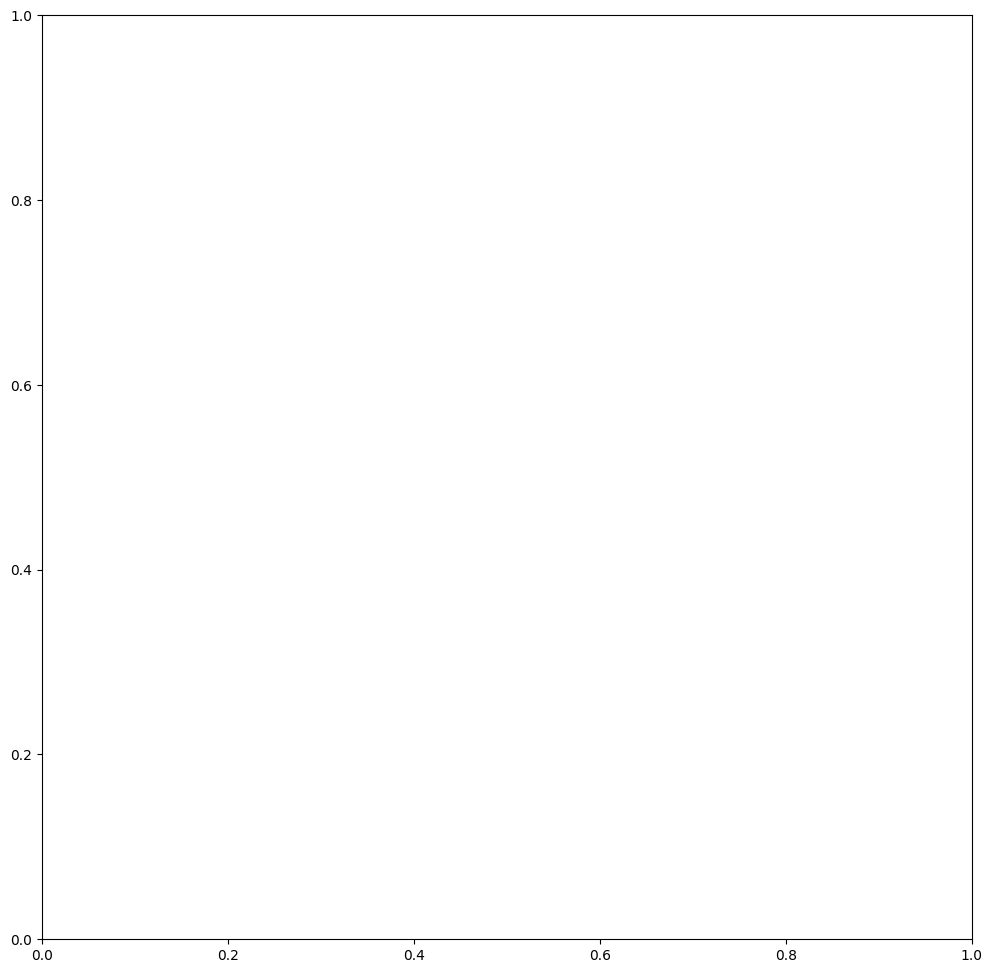

In [18]:
#Which method we are goint to test
gamma_testbench_arbitrary_limits = Gamma_Testbench(Gamma_Arbitrary_Limits, filtered_spectra)
#section related to that test
simple_gamma_section_arbitrary_limits = gamma_analysis( gamma_testbench_arbitrary_limits)

In [ ]:
#Which method are we going to test
gamma_test = Gamma_First_Two_Peaks
gamma_testbench_arbitrary_limits = Gamma_Testbench(gamma_test, filtered_spectra)
#section related to that test
simple_gamma_section_first_two_peaks = gamma_analysis( gamma_testbench_arbitrary_limits)
#create an aggregated data path
if training_data_is_used:
    aggregated_data_path =get_gamma_avg_and_std(gamma_test, filtered_spectra)


### Peaks average and standard deviation per species:
It calculates the average and standard deviation of each peak

In [ ]:
test_spectra = filtered_spectra
def peak_average_std_per_species(spectra):
    peaklists = [PeakList(spectrum) for spectrum in spectra]
    #Create a dataframe with all peaks, y peaks are normalized respect to the height of the first peak
    specimen_peak_points = pd.DataFrame([])
    for index, peaklist in enumerate(peaklists):

        peaks = peaklist.get_peaks()
        #print(f"{peaks=}")
        peak_0_x = peaks[0][0]
        peak_0_y = peaks[0][1]

        spectrum = peaklist.spectrum
        code = spectrum.code
        genus = spectrum.genus
        species= spectrum.species
        specimen_peak_points.loc[index, "code"] = code
        specimen_peak_points.loc[index, "genus"] = genus
        specimen_peak_points.loc[index, "species"] = species
        for i in range(6):
            label_x = f"x{i}"
            label_y = f"y{i}"
            specimen_peak_points.loc[index, label_x] = 0.0
            specimen_peak_points.loc[index, label_y] = 0.0
            
        for i, peak in enumerate(peaks):
            label_x = f"x{i}"
            label_y = f"y{i}"
            specimen_peak_points.loc[index, label_x] = peak[0]
            specimen_peak_points.loc[index, label_y] = peak[1]/peak_0_y

    #specimen_peak_points
    #print(specimen_peak_points)
    #print(f"{peak_avg_std_df.loc[index:]}")
    #group values by species
    averages_df = specimen_peak_points.groupby('species')[['x0', 'y0','x1', 'y1', 'x2', 'y2','x3', 'y3','x4', 'y4', 'x5', 'y5']].mean().reset_index()
    standard_deviations_df = specimen_peak_points.groupby('species')[['x0', 'y0','x1', 'y1', 'x2', 'y2','x3', 'y3','x4', 'y4', 'x5', 'y5']].std().reset_index()

    #save information
    if training_data_is_used:
        path_location = report_location /"aggregated_data"/"species_peaklist"
        create_path_if_not_exists(path_location)
        specimen_peak_points.to_csv( path_location/ 'peaks_krc.txt', index=False, sep = "\t")
        averages_df.to_csv(path_location/'peak_averages_krc.txt', index=False, sep = "\t")
        standard_deviations_df.to_csv(path_location/'peak_std_krc.txt', index=False, sep = "\t")

    #print(averages_df)
    #print(standard_deviations_df)

    return specimen_peak_points, averages_df, standard_deviations_df
specimen_peak_points, averages_df, standard_deviations_df = peak_average_std_per_species(filtered_spectra)

In [ ]:
#Create a function that calculates a similarity index given a spectrum
def similarity_index(spectrum, averages_df, standard_deviations_df , species):
    def distance(x, x0, sigma_0):
        index =  (((x - x0)**4)**(1/4))
        #print(f" x {x} - x0 {x0} = {(x - x0)} and index = {index}")
        return index
        #def get_gamma_factor(self, spectrum):
    #get first n peaks of the gamma
    n = 5
    peaklist = PeakList(spectrum)
    peaks = peaklist.get_peaks(min_wavelength_critical_points , max_wavelength_critical_points )[0:n]

    #loads species average values:

    averages_df = averages_df[averages_df["species"] == species]
    average_x_df = averages_df[["x0","x1","x2","x4","x5"]].values[0]

    standard_deviations_df = standard_deviations_df[standard_deviations_df["species"] == species]
    standard_deviation_x_df = standard_deviations_df[["x0","x1","x2","x4","x5"]].values[0]

    #print(f"averages_df: {averages_df}")
    #for each peak, calculate the distances to the averages x values
    similarity_index = 0.0

    for peak_i,xi_0, sigmai_0 in zip(peaks, average_x_df, standard_deviation_x_df):
        xi = peak_i[0]
        similarity_index += distance(xi, xi_0, sigmai_0)

    #normalize for the number of points
    similarity_index = similarity_index/n
    #print(f"gamma: {gamma}")
    return similarity_index

specimen_peak_points, averages_df, standard_deviations_df = peak_average_std_per_species(filtered_spectra)

with open(aggregated_data_avg_path, encoding= "latin1") as f:
    averages_df_0 = pd.read_csv(f, delimiter="\t", header=0)


with open(aggregated_data_std_path, encoding= "latin1") as f:
    standard_deviations_df_0 = pd.read_csv(f, delimiter="\t", header=0)




def test_tool(correct_species, kali_si, cupr_si, resp_si):
    my_list =  [kali_si, cupr_si, resp_si]
    min_index = my_list.index(min(my_list))

    if (min_index == 0):
        return "kalinini"
    if (min_index == 1):
        return "cupreomarginata"
    if (min_index == 2):
        return "resplendens"

similarity_index_text_df = pd.DataFrame([])
for k, spectrum in enumerate(filtered_spectra):
    kali_si = similarity_index(spectrum, averages_df_0, standard_deviations_df_0 , "kalinini")
    cupr_si = similarity_index(spectrum, averages_df_0, standard_deviations_df_0 , "cupreomarginata")
    resp_si = similarity_index(spectrum, averages_df_0, standard_deviations_df_0 , "resplendens")
    similarity_index_text_df.loc[k,"code"] = spectrum.code
    similarity_index_text_df.loc[k,"species"] =spectrum.species
    similarity_index_text_df.loc[k,"kali_si"] = kali_si
    similarity_index_text_df.loc[k,"cupr_si"] = cupr_si
    similarity_index_text_df.loc[k,"resp_si"] = resp_si
    similarity_index_text_df.loc[k,"prediction"] = test_tool(spectrum.species, kali_si, cupr_si, resp_si)
    #print(f"similarity indices for {spectrum.species}: kali {kali_si}, cupreo {cupr_si}, resp_si {resp_si}")
    #print(f"Test tool: {test_tool(spectrum.species, kali_si, cupr_si, resp_si)}")
print(similarity_index_text_df)
count_by_test_result = similarity_index_text_df.groupby('prediction').size().reset_index(name='count')
print(f"count {count_by_test_result}")



In [ ]:
def calculate_precision(df, species):
    print(f"{species =} \n {df=}" )
    """Precision: For a given prediction, what percentage is actually that species. """
    #filter all predictions of that particular species
    filtered_df = df[df["prediction"] == species]
    total_of_predictions = filtered_df["prediction"].count()
    print(f"{total_of_predictions=}" )
    #Now count the amount of actual species
    actual_species = filtered_df[filtered_df["species"] == species]["species"].count()
    precision = actual_species/total_of_predictions*100
    print(f"{precision=}" )
    return precision

In [ ]:
def calculate_recall(df, species):
    print(f"{species =} \n {df=}" )
    """recall: For a given species, what percentage was correctly characterized. """
    #filter all lines of a particular species
    filtered_df = df[df["species"] == species]
    total_of_species = filtered_df["species"].count()
    print(f"{total_of_species=}" )
    #Count the amount of correct predictions
    correct_predictions = filtered_df[filtered_df["prediction"] == species]["prediction"].count()
    recall = correct_predictions/total_of_species*100
    print(f"{recall=}" )
    return recall

In [ ]:
# Create sections with headings, paragraphs, and figures
def similarity_index_section(df ):

    #Define sections and results
    sections = {}
    results =[]
    information = []

    # Section 1: Introduction
    description = []
    title = [Paragraph(f"Similarity Index:", getSampleStyleSheet()["Heading2"]), Spacer(1, 12),

                    Paragraph("For each spectrum a similarity index is calculated which is the sum of the squared differences between the wavelength peak values of the unknown sample and the average wavelength peak values for each species.", getSampleStyleSheet()["Normal"]),
                    Spacer(1, 12)]
    description += title

    

    #Add table with species info

    sub_title = [Paragraph(f"Test results:", getSampleStyleSheet()["Heading3"]), Spacer(1, 6),Paragraph("The reported(correct) species is compared with the species with the lowest similarity index (si), the final column (test_result) shows if the species coincide:", getSampleStyleSheet()["Normal"]),
                    Spacer(1, 12)]

    information += sub_title
    
    #Amount of correct results

    correct_guesses  = (df['prediction'] == df["species"]).sum()
    total_guesses = df["prediction"].count()
    success_rate = correct_guesses / total_guesses * 100
    #accuracy, precision, recall, 
    comment_1 = [Paragraph(f"The amount of correct guesses is {correct_guesses} out of {total_guesses}", getSampleStyleSheet()["Heading3"]), 
                           Spacer(1, 6),
                           Paragraph(f"The accuracy (Percentage of correct classifications out of total classifications) is {success_rate:.2f} %", getSampleStyleSheet()["Normal"]),
                           Spacer(1, 12)]

    information += comment_1
    
  
    #precision and recall
    
    kali_precision = calculate_precision(df, "kalinini")
    kali_recall = calculate_recall(df, "kalinini")
    cupreo_precision = calculate_precision(df, "cupreomarginata")
    cupreo_recall= calculate_recall(df, "cupreomarginata")
    resp_precision= calculate_precision(df, "resplendens")
    resp_recall = calculate_recall(df, "resplendens")
    
    #commentary
    comment_2 = [Paragraph(f"For kalinini, precision (correct classifications out of all classifications for this species) is {kali_precision:.2f} % and recall (out of the actual specimens for this species how many were correctly classified) is {kali_recall:.2f} %.", 
                           getSampleStyleSheet()["Normal"]),
        Paragraph(f"For resplendens, precision is {resp_precision:.2f} % and recall is {resp_recall:.2f} %.", 
                           getSampleStyleSheet()["Normal"]),
        Paragraph(f"For cupreomarginata, precision is {cupreo_precision:.2f} % and recall is {cupreo_recall:.2f} %.", 
                           getSampleStyleSheet()["Normal"]),
                    Spacer(1, 12)]
    information += comment_2
    
    for column in df.columns:
        # Check if the column contains numeric values
        if pd.api.types.is_numeric_dtype(df[column]):
            # Round the values in the column to two decimal places
            df[column] = df[column].round(decimals=3)
            
    #create table with test result info
    names = df.columns.tolist()
    #names = ["a","a","a","a","a","a",]
    values_table =  df.values.tolist()

    info = [names, *values_table]
    print(info)
    #info =  df.values.tolist()
    #create table
    table2 = Table(info)
    style = TableStyle([('BACKGROUND', (0, 0), (-1, 0), colors.white),
                        ('TEXTCOLOR', (0, 0), (-1, 0), colors.black),
                        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
                        ('BACKGROUND', (0, 1), (-1, -1), colors.white),
                        ('GRID', (0, 0), (-1, -1), 1, colors.black)])

    table2.setStyle(style)
    information.append(table2)
    information.append(PageBreak())


    return description  + information

In [ ]:
similarity_index_section = similarity_index_section(similarity_index_text_df )

### Algorithm 3: Trapezoidal integration. Naive
This algorithm compares the area under the curve under the visible and IR region and compares them. Makes a cut at 800 nm

In [ ]:
class GammaAreaUnderCurveNaive(Gamma):
    #this is a subclass of Gamma
    #get_gamma_factor must be redefined
    visible_start_wavelength = uv_vis_min_wavelength
    visible_end_wavelength = ir_start_wavelength = uv_vis_ir_limit_wavelength
    ir_end_wavelength = ir_max_wavelength

    def name():
        return "Gamma_area_under_curve_naive"

    def description():
        return f"This method calculates the ratio between the area under the curve for the spectrum between {GammaAreaUnderCurveNaive.visible_start_wavelength} and {GammaAreaUnderCurveNaive.visible_end_wavelength} nm (visible range) and between {GammaAreaUnderCurveNaive.ir_start_wavelength} nm and {GammaAreaUnderCurveNaive.ir_end_wavelength} nm (Infrarred range)."


    def get_gamma_factor(self, spectrum):

        def get_area_under_curve(spectrum, start_wavelength, finish_wavelength):
            # Subset the DataFrame to the range of interest
            subset_df = df[(df['wavelength'] >= start_wavelength) & (df['wavelength'] <= finish_wavelength)]

            # Extract the wavelengths and heights as arrays
            wavelengths = subset_df['wavelength'].values
            heights = subset_df[spectrum.measuring_mode].values

            # Calculate the area under the curve using the trapezoidal rule
            area_under_curve = np.trapz(heights, wavelengths)

            print("Area under the curve:", area_under_curve)
            return area_under_curve

        import numpy as np
        df = spectrum.get_normalized_spectrum()
        area_uv_visible = get_area_under_curve(spectrum, GammaAreaUnderCurveNaive.visible_start_wavelength, GammaAreaUnderCurveNaive.visible_end_wavelength)
        area_ir = get_area_under_curve(spectrum, GammaAreaUnderCurveNaive.ir_start_wavelength, GammaAreaUnderCurveNaive.ir_end_wavelength)
        gamma = area_uv_visible/area_ir
        return gamma


### Test Gamma Under Curve: Naive

In [ ]:
#Which method we are goint to test
gamma_test = GammaAreaUnderCurveNaive
gamma_testbench_arbitrary_limits = Gamma_Testbench(gamma_test, filtered_spectra)
#section related to that test
gamma_area_under_curve_naive_section = gamma_analysis( gamma_testbench_arbitrary_limits)

### Algorithm 4: Trapezoidal integration. Minimum detection
This algorithm compares the area under the curve under the visible and IR region and compares them. Makes a cut at the first minimum

In [ ]:
def get_area_under_curve(spectrum, start_wavelength, finish_wavelength):
            # Assuming your DataFrame is named df and has columns 'wavelength' and 'height'
            # Let's say you have start_wavelength and finish_wavelength variables for the range you want to integrate over
            # Subset the DataFrame to the range of interest
            subset_df = df[(df['wavelength'] >= start_wavelength) & (df['wavelength'] <= finish_wavelength)]

            # Extract the wavelengths and heights as arrays
            wavelengths = subset_df['wavelength'].values
            heights = subset_df[spectrum.measuring_mode].values

            # Calculate the area under the curve using the trapezoidal rule
            area_under_curve = np.trapz(heights, wavelengths)

            print("Area under the curve:", area_under_curve)
            print("DEBUG method, delete in production")
            return area_under_curve

In [ ]:
class  GammaAreaFirstMinCut(Gamma):
    #this is a subclass of Gamma
    #get_gamma_factor must be redefined
    visible_range_start_wavelength = 450
    def name():
        return "gamma_area_under_curve_cut_first_minimum"
    def description():
        return f"This algorithm calculates the area for the visible region (starting at {GammaAreaFirstMinCut.visible_range_start_wavelength} and ending in the first minima between the maximum in the visible range and the maximum in the IR range. Then calculates the area of the IR range up to the second minumum. The ratio between these two areas is the gamma value."

    def get_gamma_factor(self, spectrum):

        def get_area_under_curve(spectrum, start_wavelength, finish_wavelength):
            # Assuming your DataFrame is named df and has columns 'wavelength' and 'height'
            # Let's say you have start_wavelength and finish_wavelength variables for the range you want to integrate over
            # Subset the DataFrame to the range of interest
            subset_df = df[(df['wavelength'] >= start_wavelength) & (df['wavelength'] <= finish_wavelength)]

            # Extract the wavelengths and heights as arrays
            wavelengths = subset_df['wavelength'].values
            heights = subset_df[spectrum.measuring_mode].values

            # Calculate the area under the curve using the trapezoidal rule
            area_under_curve = np.trapz(heights, wavelengths)

            # print("Area under the curve:", area_under_curve)
            return area_under_curve

        import numpy as np

        #test_spectrum = filtered_spectra[0]
        #get the highest data recorded
        max_value = spectrum.data[spectrum.measuring_mode].max()
        #get maxima and minima
        x = spectrum.data["wavelength"].values
        y = spectrum.data[spectrum.measuring_mode].values

        #get x and y positions of maxima and minima
        max_i, max_xs, max_ys = spectrum.get_maxima(min_wavelength_critical_points , max_wavelength_critical_points )
        min_i, min_xs, min_ys= spectrum.get_minima(min_wavelength_critical_points , max_wavelength_critical_points )
        #


        #get x locations of first and second maxima and the minimum in between
        first_max_x = max_xs[0]
        try:
            second_max_x = max_xs[1]
        except Exception as e:
            second_max_x = x.max()
            print(e)
        try:
            second_max_y = max_ys[1]
        except Exception as e:
            second_max_y = 0
            print(e)

        min_in_between_i = 0
        min_in_between_x =0
        min_in_between_y =0
        #get the location of the minimum in between
        for index in min_i:
            #print("index")
            if first_max_x <= x[index] <= second_max_x:
                min_in_between_i = index
                min_in_between_x = x[index]
                min_in_between_y = y[index]
                break

        # print(f"min in bet: {min_in_between_i} {min_in_between_x} {min_in_between_y} ")
        #second minimum
        #get the location of the second minimum
        min_after_second_max_i = 0
        min_after_second_max_x = 0
        min_after_second_max_y = 0
        for index in min_i:
            # print(f" second_max_x  <= x[index] { second_max_x  <= x[index]}")
            if second_max_x  <= x[index]:
                min_after_second_max_i = index
                min_after_second_max_x = x[index]
                min_after_second_max_y = y[index]
                break


        # print(f"min after: {min_after_second_max_i} {min_after_second_max_x} {min_after_second_max_y} ")

        x_values = [first_max_x, min_in_between_x, second_max_x, min_after_second_max_x]
        y_values = [max_ys[0]/max_value, min_in_between_y/max_value, second_max_y/max_value, min_after_second_max_y/max_value]
        #get the normalized spectrum
        df = spectrum.get_normalized_spectrum()
        #plot
        x = df["wavelength"].values
        y =df[spectrum.measuring_mode].values

        #modify y to have last value equal to first one
        y_mod = y
        y_mod[-1] = y_mod[0]
        
        #split x, y LEFT
        print(f"fmi: {min_in_between_i}")
        x_left = x[:min_in_between_i]
        y_left = y[:min_in_between_i]
        #set last one to zero for picture to be displaye properly
        y_left[-1] = y_left[0]
        

        #split x, y RIGHT
        #print(f"min_after_second_max_i: {min_after_second_max_i}")
        x_right = x[min_in_between_i:min_after_second_max_i]
        y_right = y[min_in_between_i:min_after_second_max_i]
        #set last one to zero for picture to be displaye properly
        y_right[0] = y_right[-1] = y_left[0]
        
        #show figure


        area_uv_visible = get_area_under_curve(spectrum, GammaAreaFirstMinCut.visible_range_start_wavelength, min_in_between_x)
        area_ir = get_area_under_curve(spectrum, min_in_between_x, min_after_second_max_x)
        gamma = area_uv_visible/area_ir
        print(f"gamma: {gamma}")
        return gamma




In [ ]:

#Which method we are goint to test
gamma_test =GammaAreaFirstMinCut
gamma_testbench_arbitrary_limits = Gamma_Testbench(gamma_test, filtered_spectra)
#section related to that test
gamma_area_first_min_cut_section = gamma_analysis( gamma_testbench_arbitrary_limits)



### Algorithm 5: Peak ratio and wavelength index

In [ ]:

class  Peak_Ratio_And_Wavelength_Similarity_Index():
    @staticmethod
    def name():
        return "Peak_Ratio_And_Wavelength_Similarity_Index"
    @staticmethod
    def description():
        return f""" This algorithm calculates the square difference for wavelength and the square difference in gamma values and multiplies them. 
Lower values are for spectra that has similar wavelengths and similar gamma values with respect to known spectra"""
    
    @staticmethod
    def gamma_similarity_index(gamma_two_peaks_aggregate_df, species, spectrum):
        def distance(x, x0, sigma_0):
            index =  (((x - x0)**2))/sigma_0
            return index
        gamma_first_two_peaks = Gamma_First_Two_Peaks(spectrum).gamma
         
        #loads species average and std values. Average is row 0 , std is row 1
    
        average_gamma_first_two_peaks = gamma_two_peaks_aggregate_df.loc[0, species]
        std_gamma_first_two_peaks = gamma_two_peaks_aggregate_df.loc[0, species]

        #calculates similarity index
        similarity_index = distance(gamma_first_two_peaks, average_gamma_first_two_peaks,std_gamma_first_two_peaks)
        
        return similarity_index

    def __init__( self, spectrum):
        self.spectrum = spectrum
        
    def get_indices_df(self):
        spectrum = self.spectrum
        gamma = 0
        #Reads the file with aggregated data for each species
        #aggregated_data_gamma_two_peaks = aggregated_data_location + "\\aggregated_data\\gammaGamma_First_Two_Peaks.txt"
        aggregated_data_gamma_two_peaks = os.path.join(aggregated_data_location, "aggregated_data","gammaGamma_First_Two_Peaks.txt")
        #read gamma averages per species
        gamma_two_peaks_aggregate_df = pd.read_csv(aggregated_data_gamma_two_peaks, delimiter="\t")
        
        
        #read peak averages and std
        peak_averages_df = pd.read_csv(aggregated_data_avg_path, delimiter = "\t")
        peak_std_df = pd.read_csv(aggregated_data_std_path, delimiter = "\t")

        #An empty dataframe with species info and gamma and wavelength square differences will be created

        indices_df = pd.DataFrame([])
        #species_list
        species_list = gamma_two_peaks_aggregate_df.columns
        for species in species_list:
            #gamma is calculated
            indices_df.loc[species,"gamma_similarity_index"] = gamma_similarity_index_value = Peak_Ratio_And_Wavelength_Similarity_Index.gamma_similarity_index(gamma_two_peaks_aggregate_df, species, spectrum)
            
            
            #square difference is calculated
            peak_similarity_index_value= similarity_index(spectrum, peak_averages_df, peak_std_df , species)
            indices_df.loc[species,"peak_similarity_index"] = peak_similarity_index_value

            
            #total
            indices_df.loc[species,"product"] = gamma_similarity_index_value*peak_similarity_index_value
            
        return indices_df
    


In [ ]:
test_df = pd.DataFrame([])
for index, spectrum in enumerate(filtered_spectra):
    test_df.loc[index, "code"] = spectrum.code
    test_df.loc[index, "species"] = spectrum.species
    #get index df for each species
    index_df = Peak_Ratio_And_Wavelength_Similarity_Index(spectrum).get_indices_df()
    #print(index_df)
    test_df.loc[index, "cupreomarginata"] = index_df.loc["cupreomarginata", "product"]
    test_df.loc[index, "kalinini"] = index_df.loc["kalinini", "product"]
    test_df.loc[index, "resplendens"] = index_df.loc["resplendens", "product"]
    #get minimum value
    

test_df["prediction"]  = test_df[['cupreomarginata', 'kalinini', 'resplendens']].idxmin(axis=1)

print(test_df)
# gamma_test =Peak_Ratio_And_Wavelength_Index
# bp_path =gamma_testbench(gamma_test, filtered_spectra)
# print(f"type {type(bp_path)} bp_path")
# gamma_area_first_min_cut_section = gamma_analysis( gamma_test, bp_path  , "", "")

#### Peak_Ratio_And_Wavelength_Similarity_Index section

In [ ]:
### SECTION
def Peak_Ratio_And_Wavelength_Similarity_Index_section(df ):
    
    #Define sections and results
    sections = {}
    results =[]
    information = []

    # Section 1: Introduction
    description = []
    title = [Paragraph(f"{Peak_Ratio_And_Wavelength_Similarity_Index.name()}:", getSampleStyleSheet()["Heading2"]), Spacer(1, 12),

                    Paragraph(f"{Peak_Ratio_And_Wavelength_Similarity_Index.description()}", getSampleStyleSheet()["Normal"]),
                    Spacer(1, 12)]
    description += title


    
    
    #Add table with species info

    sub_title = [Paragraph(f"Test results:", getSampleStyleSheet()["Normal"]), Spacer(1, 6),Paragraph("The reported(correct) species is compared with the species with the lowest similarity index (si), the final column (test_result) shows if the species coincide:", getSampleStyleSheet()["Normal"]),
                    Spacer(1, 12)]
    
    information += sub_title
    
    #Amount of correct results

    correct_guesses  = (df['species'] == df['prediction']).sum()
    total_guesses = df["prediction"].count()
    success_rate = correct_guesses / total_guesses * 100
    
    comment_1 = [Paragraph(f"The amount of correct guesses is {correct_guesses} out of {total_guesses}", getSampleStyleSheet()["Heading3"]), 
                           Spacer(1, 6),
                           Paragraph(f"The accuracy (Percentage of correct classifications out of total classifications) is {success_rate:.2f} %", getSampleStyleSheet()["Normal"]),
                           Spacer(1, 12)]

    information += comment_1
    
    #precision and recall
    
    kali_precision = calculate_precision(df, "kalinini")
    kali_recall = calculate_recall(df, "kalinini")
    cupreo_precision = calculate_precision(df, "cupreomarginata")
    cupreo_recall= calculate_recall(df, "cupreomarginata")
    resp_precision= calculate_precision(df, "resplendens")
    resp_recall = calculate_recall(df, "resplendens") #
    
    #commentary
    comment_2 = [Paragraph(f"For kalinini, precision (correct classifications out of all classifications for this species) is {kali_precision:.2f} % and recall (out of the actual specimens for this species how many were correctly classified) is {kali_recall:.2f} %.", 
                           getSampleStyleSheet()["Normal"]),
        Paragraph(f"For resplendens, precision is {resp_precision:.2f} % and recall is {resp_recall:.2f} %.", 
                           getSampleStyleSheet()["Normal"]),
        Paragraph(f"For cupreomarginata, precision is {cupreo_precision:.2f} % and recall is {cupreo_recall:.2f} %.", 
                           getSampleStyleSheet()["Normal"]),
                    Spacer(1, 12)]
    information += comment_2
                  
    #create table with test result info
    
    #round column values
    for column in df.columns:
        # Check if the column contains numeric values
        if pd.api.types.is_numeric_dtype(df[column]):
            # Round the values in the column to two decimal places
            df[column] = df[column].round(decimals=3)
    #convert columns to list
    names = df.columns.tolist()
    
    values_table =  df.values.tolist()

    info = [names, *values_table]
    #print(info)
    #info =  df.values.tolist()
    #create table
    table2 = Table(info)
    style = TableStyle([('BACKGROUND', (0, 0), (-1, 0), colors.white),
                        ('TEXTCOLOR', (0, 0), (-1, 0), colors.black),
                        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
                        ('BACKGROUND', (0, 1), (-1, -1), colors.white),
                        ('GRID', (0, 0), (-1, -1), 1, colors.black)])

    table2.setStyle(style)
    information.append(table2)
    information.append(PageBreak())


    return description  + information

In [ ]:
peak_ratio_and_wavelength_similarity_index_section= Peak_Ratio_And_Wavelength_Similarity_Index_section(test_df )

### Create Report 

In [ ]:
# Create PDF report
def create_report():
    elements = create_title_page()
    #sections, sections_start_pages = create_sections()
    elements += specimen_section
    elements += simple_gamma_section_arbitrary_limits 
    elements += simple_gamma_section_first_two_peaks
    elements += gamma_area_under_curve_naive_section
    elements += gamma_area_first_min_cut_section
    elements += similarity_index_section
    elements += peak_ratio_and_wavelength_similarity_index_section
    #elements += create_table_of_contents()

    ##elements += sections
    elements += create_bibliography()

    # # Update table of contents with page numbers
    # toc_style = getSampleStyleSheet()["Heading1"]
    # #toc_data = [[Paragraph(section, toc_style), str(page_num)] for section, page_num in sections_start_pages.items()]
    # toc_data = ["1"]
    # toc_table = Table(toc_data)
    # toc_table.setStyle(TableStyle([('ALIGN', (0, 0), (-1, -1), 'CENTER')]))
    # elements[-1] = toc_table
    # elements += create_table_of_contents(toc_data)
    
    location = os.path.join(report_location, f"gamma analysis {collection_names} {current_date}.pdf" )
    doc = SimpleDocTemplate(location, pagesize=letter)
    doc.build(elements)
    print(f"The report was saved at {location} ")
create_report()

###